# Terminal currents

<img src="../images/logo_terminal_currents.png"
     alt="S-shaped device with terminal current"
     width="200"
     align="center"
/>

Supercurrent in a `superscreen.Device` can be classified into one of three categories:

1. **Screening currents**, which are the response of a film to an applied magnetic field.
2. **Circulating currents**, which are the response of a film to flux trapped in a hole.
3. **Terminal currents**, which flow into and out of a film through "transport terminals" defined on the film boundary.

In this notebook we demonstrate the treatment of **terminal currents** in a `superscreen` model.

## Background

We make the following assumptions regarding terminal currents:

1. The current density $|\vec{J}|$ is uniformly distributed along the terminal.
2. Along the terminal, the current direction $\vec{J}/|\vec{J}|$ is perpendicular to the terminal direction.

The stream function $g(\vec{r})=g(x, y)$ and 2D supercurrent density $\vec{J}(x, y)$ are related according to $\vec{J}=\vec{\nabla}\times(g\hat{z})=(\partial g/\partial y, -\partial g/\partial x)$. For some assumed supercurrent distribution $\vec{J},$ the associated stream function $g$ is given by a line integral,

$$g(\vec{r})=g(\vec{r}_0) + \int_{\vec{r}_0}^\vec{r}(\hat{z}\times\vec{J})\cdot\mathrm{d}\vec{\ell},$$

where $\hat{z}\times\vec{J}=(-J_y, J_x)$ and $\vec{r}_0$ is some reference position.

The stream function $g$ in a film can be decomposed into $g=g_\mathrm{screening}+g_\mathrm{transport},$ where $g_\mathrm{screening}$ arises from the response to an applied magnetic field or trapped flux, and $g_\mathrm{transport}$ corresponds to an applied current bias. Below we describe how to set $g_\mathrm{transport}(\vec{r})$ for a given current bias configuration.

### Stream function on the boundary

The boundary conditions for terminal currents are as follows:

- The boundary of the film is oriented in a counterclockwise direction.
- The stream function $g_\mathrm{transport}(\vec{r})$ along a source terminal $s$ injecting current $I_s$ changes linearly by a total amount $-I_s,$ and $g_\mathrm{transport}(\vec{r})$ for $\vec{r}$ along the terminal is given by the equation above, where $\vec{r}_0$ is the start of the terminal.
- The stream function $g_\mathrm{transport}(\vec{r})$ on the boundary between terminals is constant.
- There is a single drain terminal in the system, along which the stream function $g_\mathrm{transport}(\vec{r})$ changes linearly by a total amount $\sum_sI_s,$ ensuring current conservation.
- When the terminals are oriented in a counterclockwise direction, the boundary immediately after the drain terminal is the "reference boundary," along which $g_\mathrm{transport}(\vec{r})=0$.

<img src="../images/transport-boundary.png"
     alt="Transport current boundary conditions"
     width="200"
     align="center"
/>

### Stream function in the bulk

Once $g_\mathrm{transport}(\vec{r}_\text{boundary})$ has been defined for all $\vec{r}_\text{boundary}$ on the film's boundary, we solve for $g_\mathrm{transport}(\vec{r}_\text{bulk})$ inside the film as follows.

1. First we find an "effective field" $H_{z,\,\text{eff}}(\vec{r})$ that would generate such a $g_\mathrm{transport}(\vec{r}_\text{boundary})$ in a film with (effectively) infinite penetration depth $\Lambda\to\infty$.
2. Once $H_{z,\,\text{eff}}(\vec{r})$ is found, $g_\mathrm{transport}(\vec{r}_\text{bulk})$ is given by the response of the hypothetical film with $\Lambda\to\infty$ to this applied effective field.

The effective field $H_{z,\,\mathrm{eff}}$ is found by embedding the film in a (hypothetical) loop with a given circulating current $I_\mathrm{circ}$ (see figure below). For $\Lambda$ much larger than the size of the film and $I_\mathrm{circ}=I_s,$ this setup produces a uniform current distribution in the film with total current $I_s$ as desired.

<img
     src="../images/transport-setup.png"
     alt="Transport current boundary conditions"
     width="300"
     align="center"
/>

### Stream function in holes

For films with holes, we first solve for $g_\mathrm{transport}(\vec{r})$ as described [above](#Stream-function-in-the-bulk) *assuming that there are no holes*. Then, for each hole $h$ we update $g_\mathrm{transport}(\vec{r})$ for $\vec{r}$ inside $h$ to be equal to the average value over the hole area:
$$g_\mathrm{transport}(\vec{r})\to \frac{1}{\mathrm{area}(h)}\int_h g_\mathrm{transport}(\vec{r}')\,\mathrm{d}^2r'\quad\forall\:\vec{r}\text{ in hole }h$$

## Examples

In [1]:
# Automatically install superscreen from GitHub only if running in Google Colab
if "google.colab" in str(get_ipython()):
    %pip install --quiet git+https://github.com/loganbvh/superscreen.git

In [2]:
%config InlineBackend.figure_formats = {"retina", "png"}
%matplotlib inline

import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams["font.size"] = 10

import superscreen as sc
from superscreen.geometry import box, circle, rotate

In [3]:
sc.version_table()

Software,Version
SuperScreen,0.10.5
Numpy,1.23.3
Numba,0.57.0
SciPy,1.9.1
matplotlib,3.6.0
IPython,8.5.0
Python,"3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) [Clang 13.0.1 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 10, Logical: 10"
BLAS Info,OPENBLAS


### Film with a constriction

Define the device geometry.

The source terminal(s) and drain terminal are defined as instances of `superscreen.Polygon`. All points in the mesh that are inside a terminal polygon **and** on the boundary of the mesh will have the transport boundary conditions applied.

In [4]:
width = 1
height = width * 2
slot_height = height / 5
slot_width = width / 4
x0, y0 = center = (0, 0)
length_units = "um"

film = sc.Polygon("film", layer="base", points=box(width, height))
slot = sc.Polygon(points=box(slot_width, slot_height, center=(-(width - slot_width) / 2, 0)))
film = film.difference(slot, slot.translate(dx=width - slot_width)).resample(251)

source_terminal = sc.Polygon(
    "source", points=box(width, height / 100, center=(0, height / 2))
)
drain_terminal = source_terminal.translate(dy=-height).set_name("drain")

device = sc.Device(
    "constriction",
    layers=[sc.Layer("base", Lambda=0.1)],
    films=[film],
    terminals={film.name: [source_terminal, drain_terminal]},
    length_units=length_units,
)

In [5]:
device.make_mesh(min_points=3000, smooth=50)

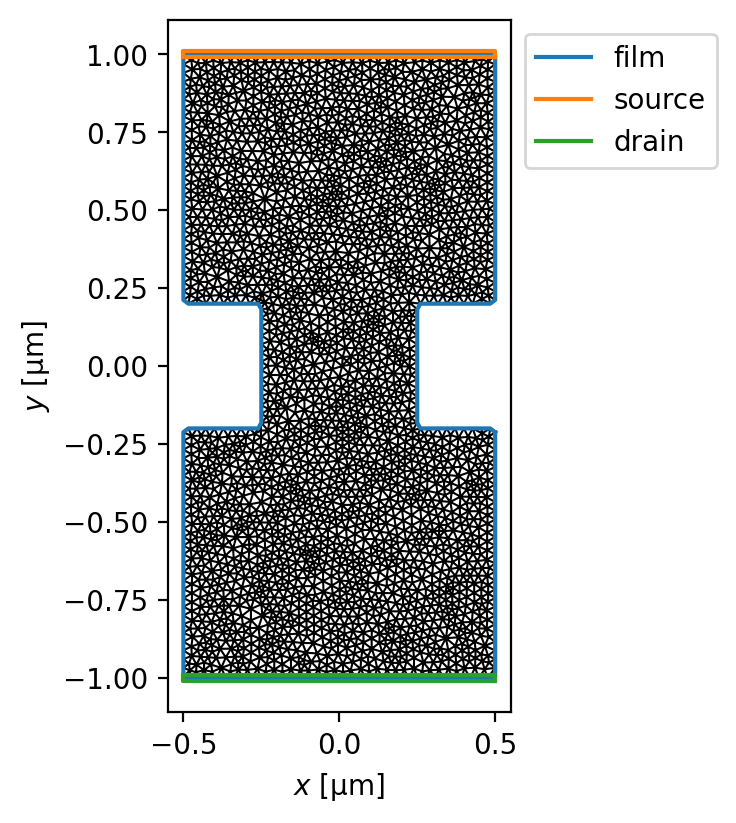

In [6]:
fig, ax = device.plot_mesh(edge_color="k", show_sites=False)
_ = device.plot_polygons(ax=ax, legend=True)

Solve the device with a given source-drain current and no applied field.

In [7]:
terminal_currents = {"film": {"source": "100 uA", "drain": "-100 uA"}}

solution = sc.solve(
    device,
    applied_field=sc.sources.ConstantField(0),
    terminal_currents=terminal_currents,
)[-1]

Plot the stream function.

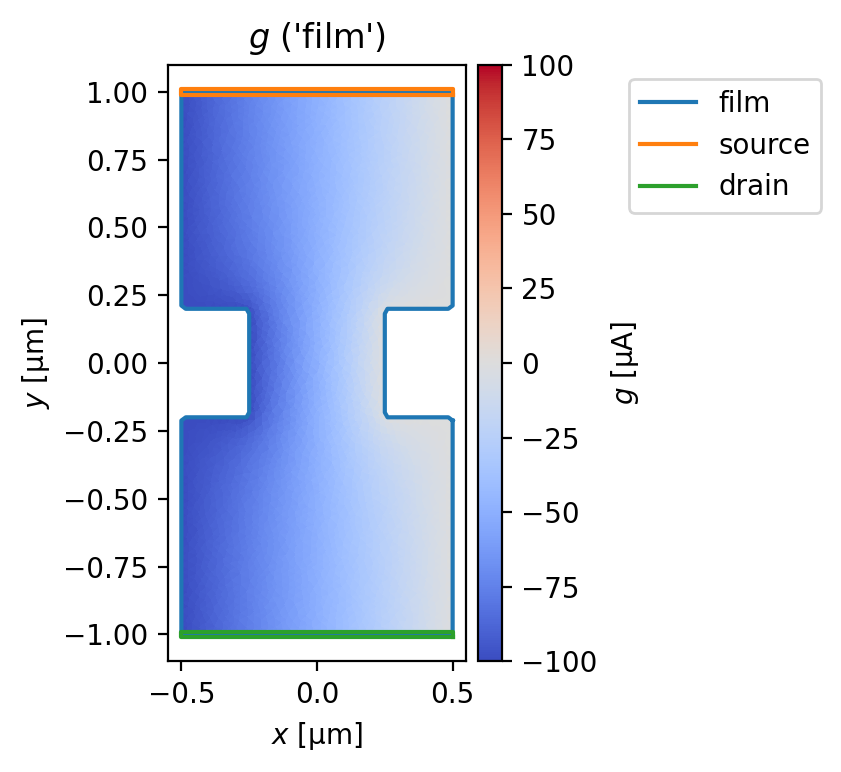

In [8]:
fig, axes = solution.plot_streams()
_ = device.plot_polygons(ax=axes[0])
_ = axes[0].legend(loc="upper left", bbox_to_anchor=(1.5, 1))

Plot the supercurrent distribution.

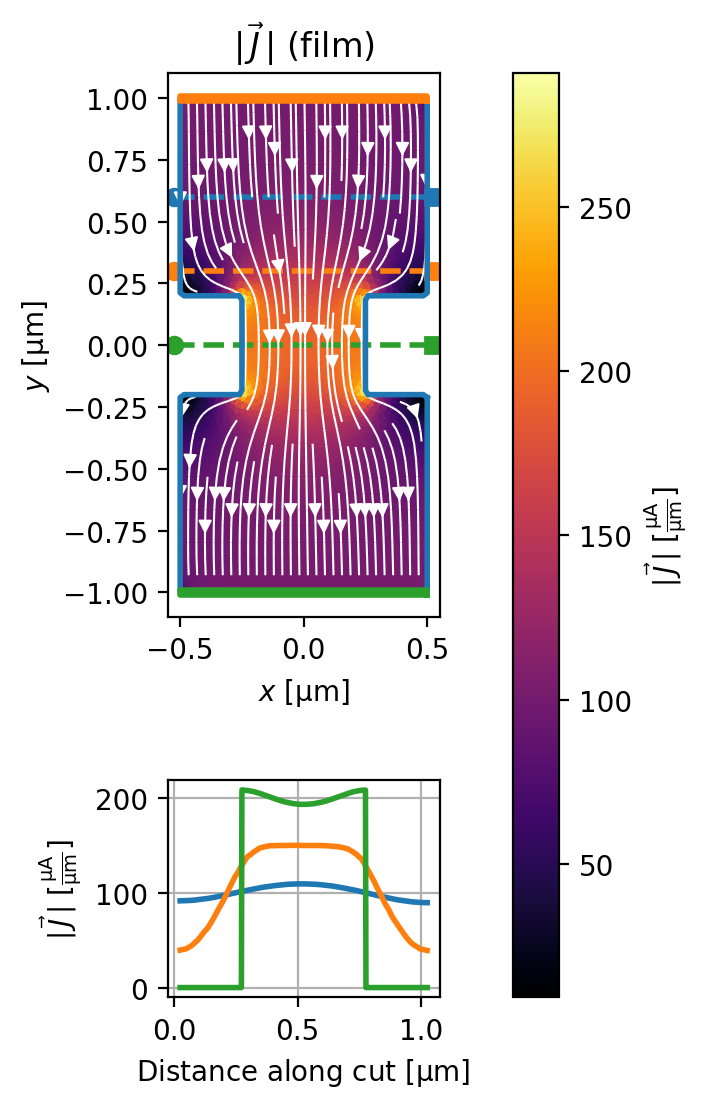

In [9]:
xs = np.linspace(-(1.05 * width) / 2, (1.05 * width) / 2, 501)
ys = np.ones_like(xs)

sections = [
    np.stack([xs, 0.6 * ys], axis=1),
    np.stack([xs, 0.3 * ys], axis=1),
    np.stack([xs, 0.0 * ys], axis=1),
]

fig, axes = solution.plot_currents(
    streamplot=True,
    cross_section_coords=sections,
    figsize=(3, 6),
)
_ = device.plot_polygons(ax=axes[0], lw=2)

Compute the total current flowing through the various cross-sections.

In [10]:
for coords in sections:
    total_current = solution.current_through_path(coords, film="film", units="uA").magnitude
    target_current = solution.terminal_currents["film"]["source"]
    err = (total_current - target_current) / abs(target_current) * 100
    print(
        f"Cross-section: y = {coords[0, 1]:.2f} um, total current = {total_current:.3f} uA"
        f" ({err:.2f}% error)"
    )

Cross-section: y = 0.60 um, total current = 99.967 uA (-0.03% error)
Cross-section: y = 0.30 um, total current = 100.013 uA (0.01% error)
Cross-section: y = 0.00 um, total current = 99.954 uA (-0.05% error)


### Film with holes

In [11]:
device.holes = {
    "hole1": sc.Polygon(
        "hole1",
        layer="base",
        points=circle(width / 4, center=(-width / 8, +height / 4)),
    ),
    "hole2": sc.Polygon(
        "hole2",
        layer="base",
        points=circle(width / 4, center=(+width / 8, -height / 4)),
    ),
}

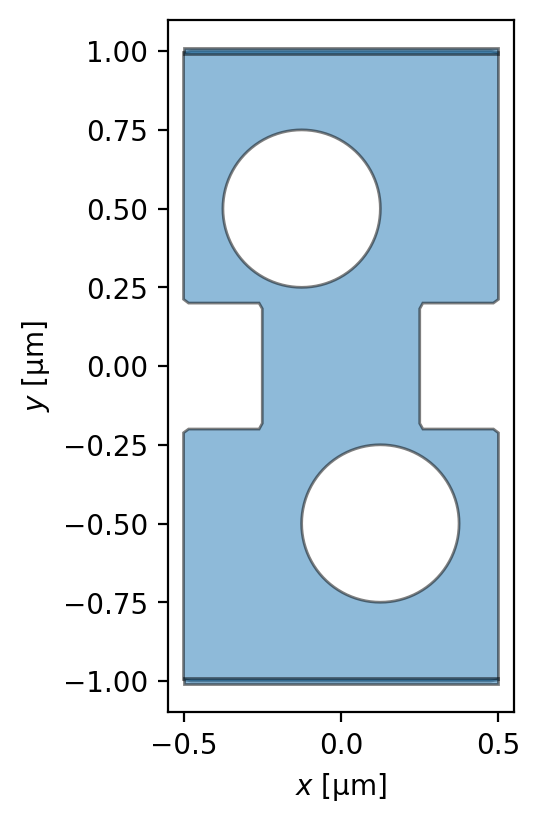

In [12]:
_ = device.draw()

#### Find the zero-fluxoid solution for a given source-drain current.

Note that if the two holes were horizontally aligned in the center of the device (such that the device was mirror-symmetric about $x=0$), then by symmetry the zero-fluxoid solution would have no circulating current.

In [13]:
terminal_currents = {"film": {"source": "100 uA", "drain": "-100 uA"}}

solution = sc.find_fluxoid_solution(
    device,
    applied_field=sc.sources.ConstantField(0),
    terminal_currents=terminal_currents,
)

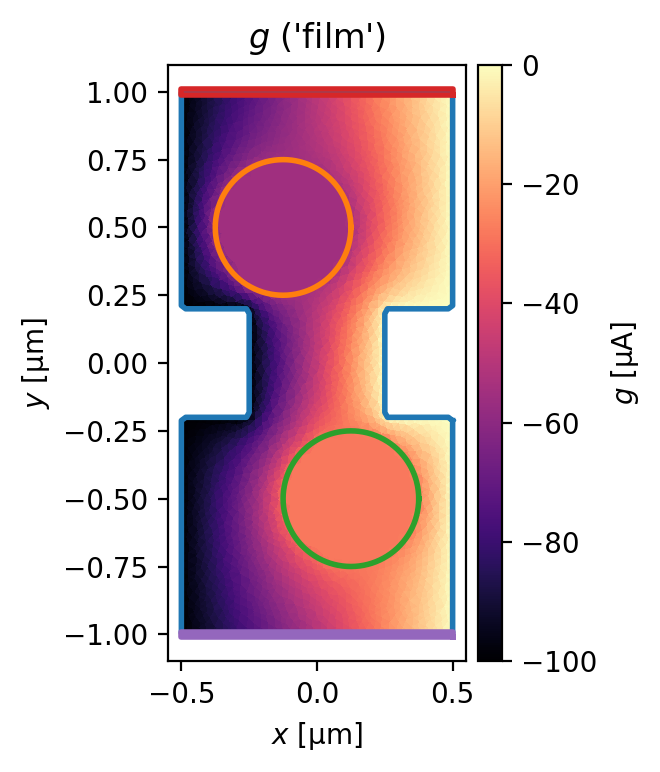

In [14]:
fig, axes = solution.plot_streams(symmetric_color_scale=False, cmap="magma")
_ = device.plot_polygons(ax=axes[0], lw=2)

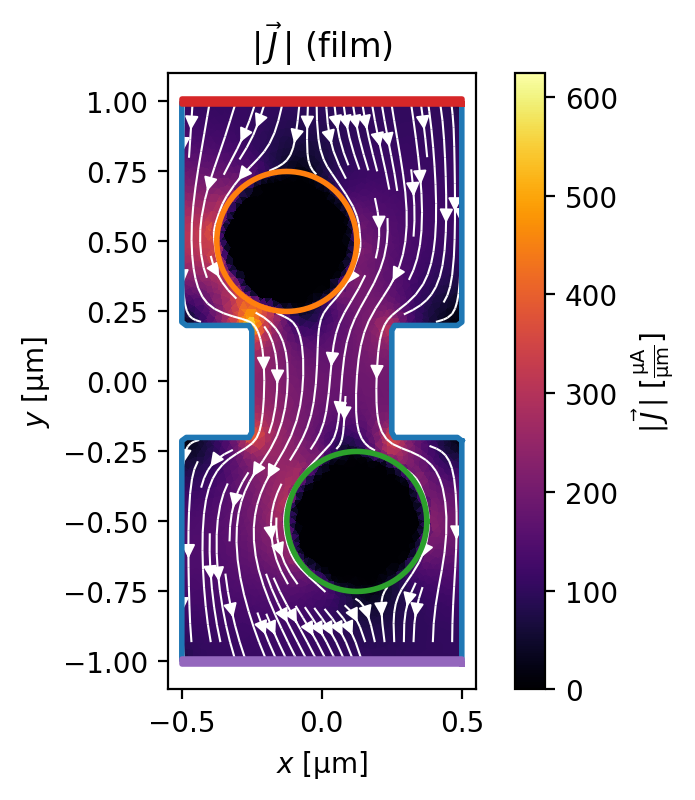

In [15]:
fig, axes = solution.plot_currents(streamplot=True)
_ = device.plot_polygons(ax=axes[0], lw=2)

### Parallel SQUID array model

Here we model a device studied in detail in *Theoretical model for parallel SQUID arrays with fluxoid focusing*, [Phys. Reb. B 103, 054509 (2021)](https://doi.org/10.1103/PhysRevB.103.054509) ([arXiv:2009.05338](https://arxiv.org/abs/2009.05338)).

The device consists of a $d=0.125\,\mu\mathrm{m}$ thick YBCO film with an estimated London penetration depth of $\lambda=0.3\,\mu\mathrm{m}$. The film is pattered into a device with approximately the dimensions shown below. The device has source and drain leads at the top and bottom respectively, and 10 rectangular holes along the vertical midpoint.

Among other things, the authors simulated the current distribution for a total source-drain current of $200\,\mu\mathrm{A}$ with both $0\,\mu\mathrm{T}$ and $12\,\mu\mathrm{T}$ out-of-plane applied field. Those results, plotted as current streamlines for the top half of the device, are shown in Figure 5 of the paper linked above (which is reproduced below).

<img
     src="../images/PhysRevB.103.054509-Fig5.png"
     alt="Figure 5 from https://doi.org/10.1103/PhysRevB.103.054509"
     width="500"
     align="center"
/>

Below we demonstrate how to reproduce these results using `SuperScreen`.

In [16]:
layer = sc.Layer("base", london_lambda=0.3, thickness=0.125)
film = sc.Polygon("film", layer="base", points=box(60, 24)).union(box(10, 40)).resample(401)
w_h, h = 4, 2
base_hole = sc.Polygon(layer="base", points=box(w_h, 2 * w_h)).resample(51)
holes = []
for i in range(10):
    hole = base_hole.translate(dx=1.5 * h + (i - 5) * w_h * 1.5, dy=0)
    hole.name = f"hole{i}"
    holes.append(hole)

source = sc.Polygon("source", points=box(10, 0.1, center=(0, 20)))
drain = sc.Polygon("drain", points=box(10, 0.1, center=(0, -20)))

device = sc.Device(
    "squid_array",
    films=[film],
    layers=[layer],
    holes=holes,
    terminals={film.name: [source, drain]},
    length_units="um",
)

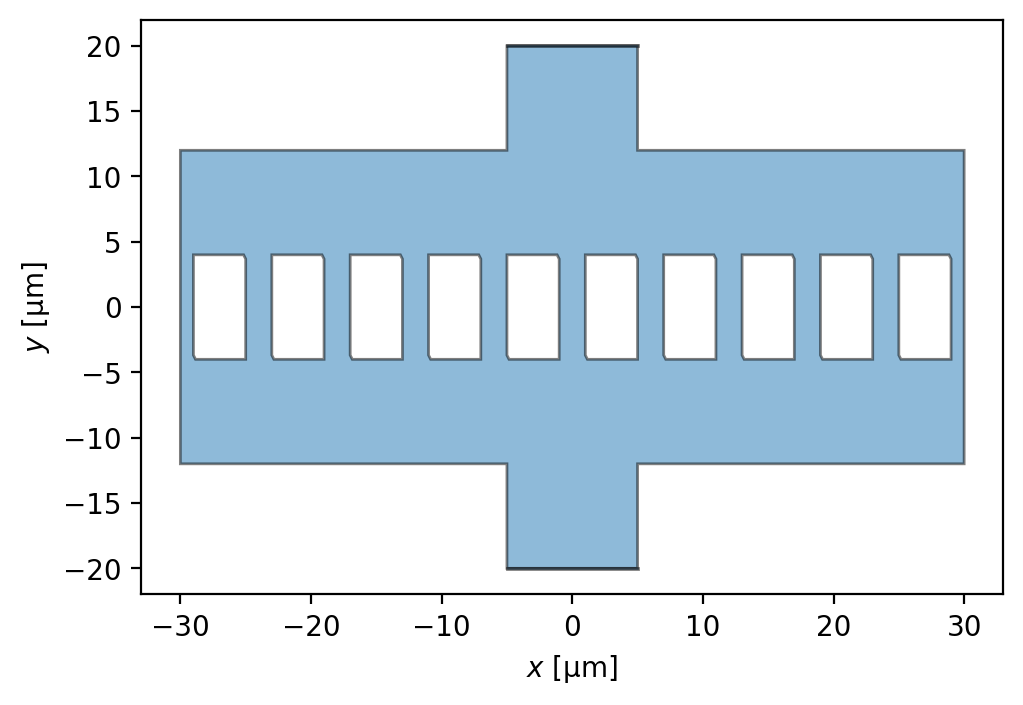

In [17]:
fig, ax = device.draw()

In [18]:
device.make_mesh(max_edge_length=1.25, smooth=50)

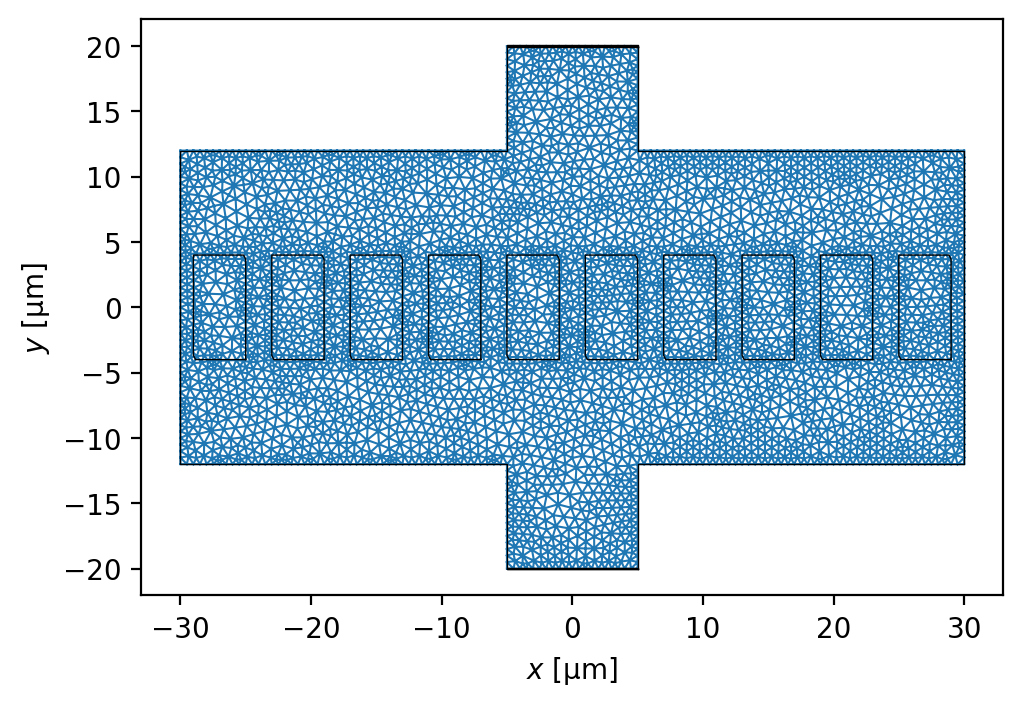

In [19]:
fig, ax = device.plot_mesh()
_ = device.plot_polygons(ax=ax, color="k", lw=0.5)

In [20]:
# Region in which we will evaluate the field from the device.
eval_region = sc.Polygon(points=box(60, 40))
eval_mesh = eval_region.make_mesh(max_edge_length=1.5)

In [21]:
def solve_and_plot_model(source_current="200 uA", applied_field="0 uT"):
    # Solve the model
    applied_field = sc.ureg(applied_field).to("uT").magnitude
    solution = sc.solve(
        device,
        applied_field=sc.sources.ConstantField(applied_field),
        terminal_currents={"film": {"source": source_current, "drain": f"-{source_current}"}},
        field_units="uT",
    )[-1]

    # Define cross sections
    xs = np.linspace(-64 / 2, +64 / 2, 501)
    ys = np.ones_like(xs)
    sections = [
        np.array([xs, 15.0 * ys]).T,
        np.array([xs, 10.0 * ys]).T,
        np.array([xs, 7.5 * ys]).T,
        np.array([xs, 0.0 * ys]).T,
    ]

    # Plot currents.
    fig, axes = solution.plot_currents(
        streamplot=True,
        min_stream_amp=1e-4,
        cross_section_coords=sections,
        figsize=(5, 4),
    )
    _ = device.plot_polygons(ax=axes[0], lw=1, color="w", ls="--")

    # Evaluate the current through each cross section.
    for coords in sections:
        total_current = solution.current_through_path(coords, film="film", units="uA").magnitude
        target_current = solution.terminal_currents["film"]["source"]
        err = (total_current - target_current) / abs(target_current) * 100
        print(
            f"Cross-section: y = {coords[0, 1]:.2f} um, total current = {total_current:.3f} uA"
            f" ({err:.2f}% error)"
        )

    # Plot fields    
    fig, ax = solution.plot_field_at_positions(
        eval_mesh,
        zs=0.75,
        cross_section_coords=sections,
        figsize=(5, 4),
    )
    _ = device.plot_polygons(ax=ax, lw=1, color="w", ls="--")

    return solution

Applied field = $0\,\mu\mathrm{T}$

Cross-section: y = 15.00 um, total current = 199.641 uA (-0.18% error)
Cross-section: y = 10.00 um, total current = 199.652 uA (-0.17% error)
Cross-section: y = 7.50 um, total current = 199.972 uA (-0.01% error)
Cross-section: y = 0.00 um, total current = 203.844 uA (1.92% error)


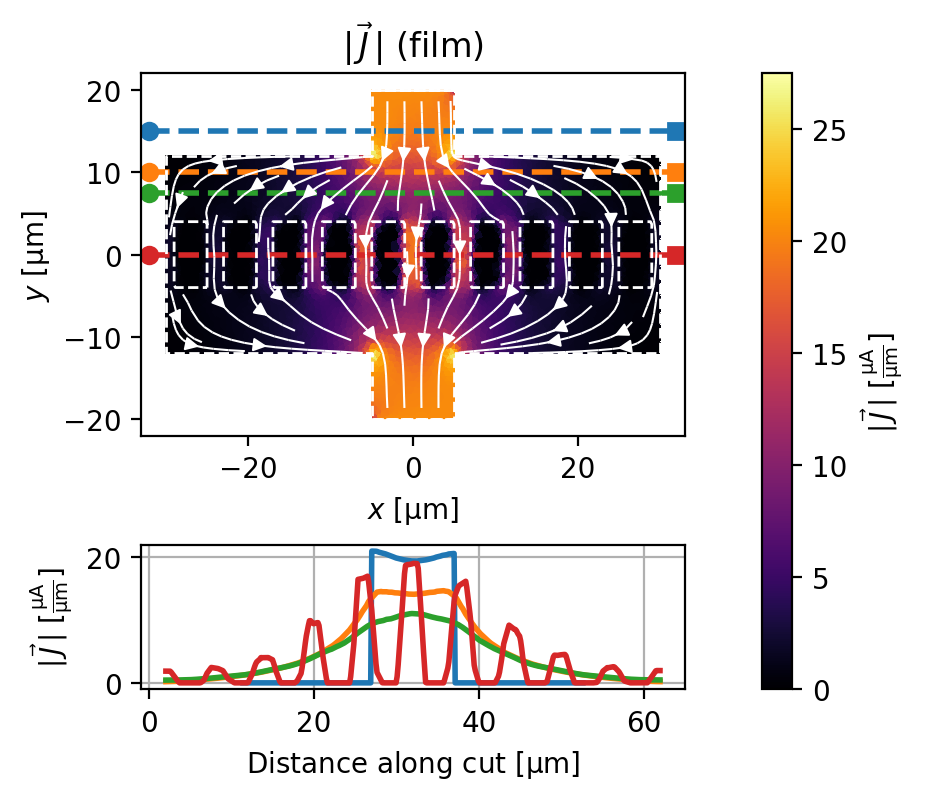

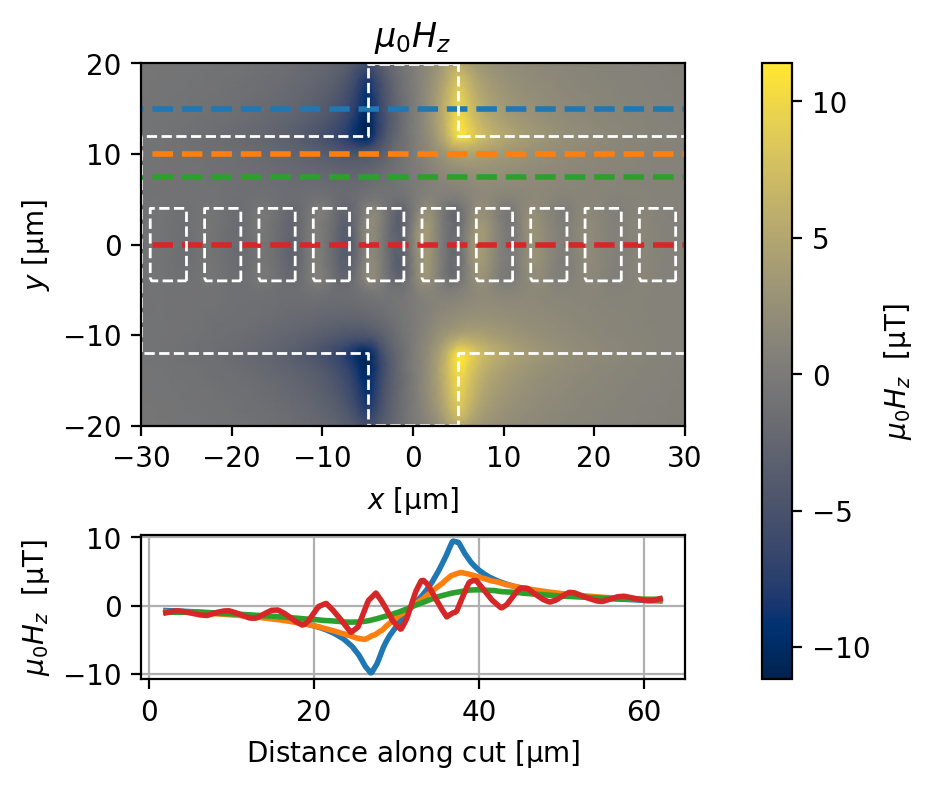

In [22]:
solution_0uT = solve_and_plot_model(source_current="200 uA", applied_field="0 uT")

Applied field = $12\,\mu\mathrm{T}$

Cross-section: y = 15.00 um, total current = 199.192 uA (-0.40% error)
Cross-section: y = 10.00 um, total current = 198.589 uA (-0.71% error)
Cross-section: y = 7.50 um, total current = 199.536 uA (-0.23% error)
Cross-section: y = 0.00 um, total current = 202.799 uA (1.40% error)


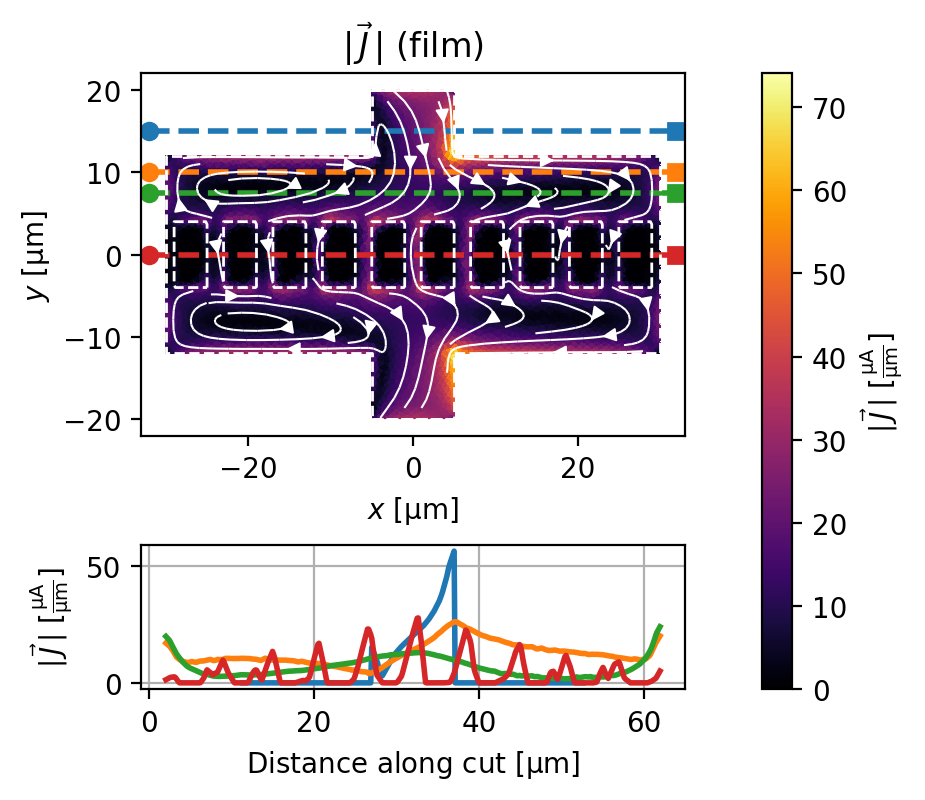

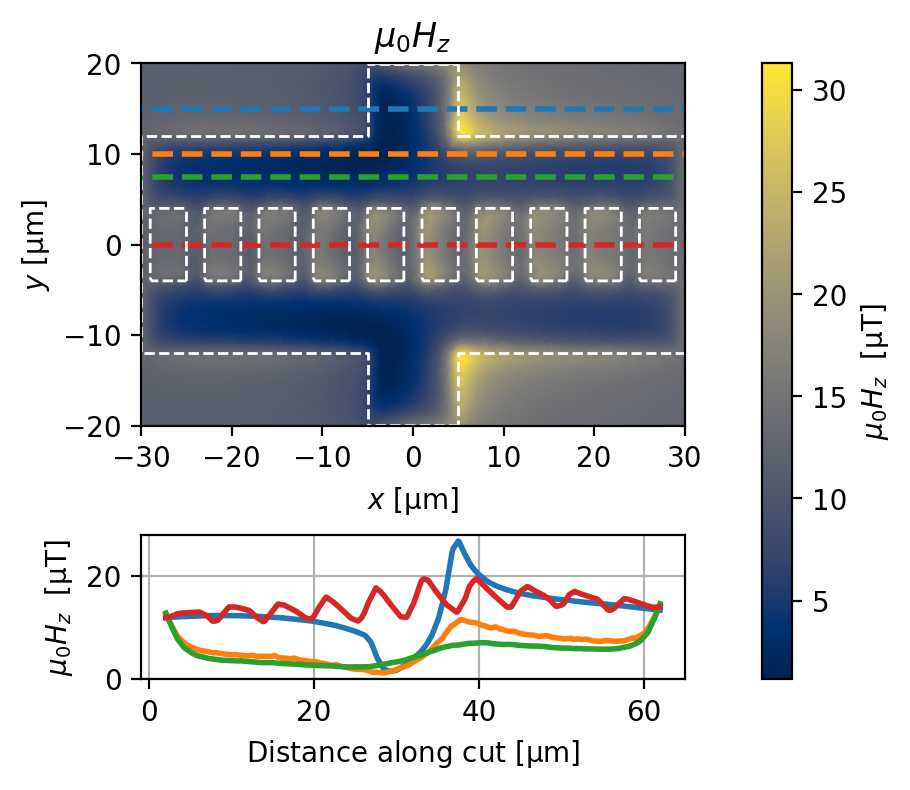

In [23]:
solution_12uT = solve_and_plot_model(source_current="200 uA", applied_field="12 uT")

### Multiple source terminals

As mentioned above, while there can be aribitrarily many source terminals, there can technically only be a single drain terminal. However, it is possible to model systems with multiple current sinks by changing the the sign of terminal currents.

Below we demonstrate this with a "+"-shaped device with four current terminals.

In [24]:
layer = sc.Layer("base", Lambda=1)
width, height = 10, 2
points = box(width, height)
bar = sc.Polygon("plus", points=points)
plus = bar.union(bar.rotate(90)).resample(501)
plus.name = "plus"
plus.layer = layer.name
terminal = sc.Polygon(points=box(height, width / 50, center=(0, -width / 2)))

terminals = []
for i, name in enumerate(["drain", "source1", "source2", "source3"]):
    term = terminal.rotate(i * 90)
    term.name = name
    terminals.append(term)

device = sc.Device(
    "plus",
    films=[plus],
    layers=[layer],
    terminals={"plus": terminals},
    length_units="um",
)

In [25]:
device.make_mesh(max_edge_length=0.3, smooth=50)

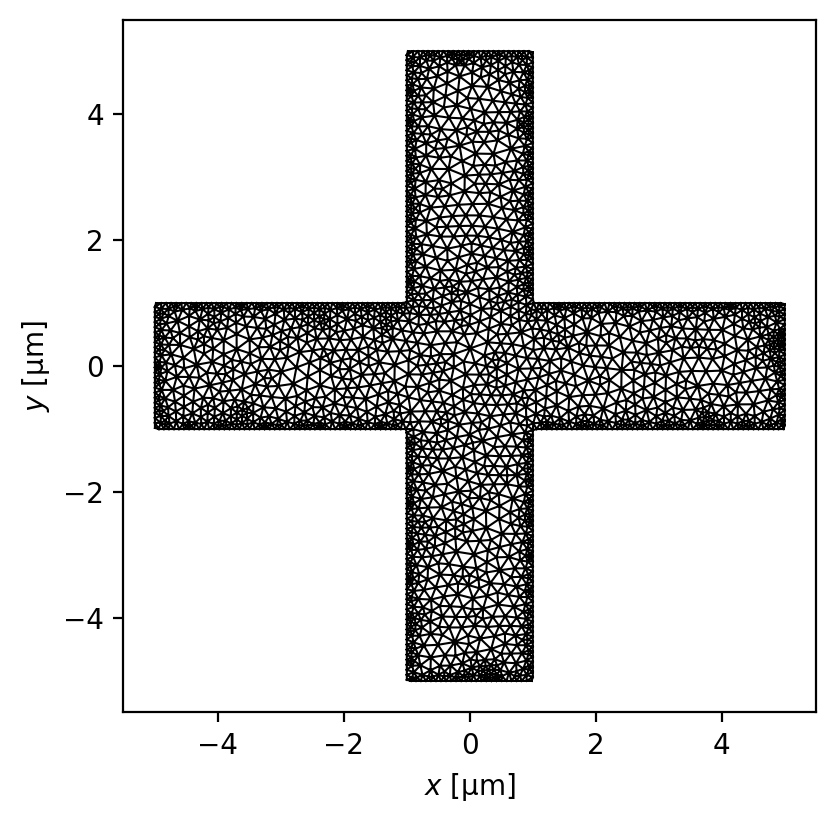

In [26]:
_ = device.plot_mesh(edge_color="k")

In [27]:
def solve_and_plot_model(terminal_currents, applied_field="0 uT"):
    # Define cross-sections for each terminal
    xs = np.linspace(-1.5, 1.5, 201)
    ys = -3 * np.ones_like(xs)
    rs = np.stack([xs, ys], axis=1)
    sections = [rotate(rs, i * 90) for i in range(4)]
    # Put the drain at the end of the list
    sections.append(sections.pop(0))

    # Solve the model
    applied_field = sc.ureg(applied_field).to("uT").magnitude
    solution = sc.solve(
        device,
        terminal_currents=terminal_currents,
        applied_field=sc.sources.ConstantField(applied_field),
        current_units="uA",
        field_units="uT",
    )[-1]
    
    terminal_currents = solution.terminal_currents["plus"]
    target_currents = list(terminal_currents.values()) + [None]

    # Calculate the total current though each terminal
    for coords, target, name in zip(sections, target_currents, terminal_currents):
        current = solution.current_through_path(coords, film="plus", units="uA").magnitude
        if target is None:
            # This is the drain terminal. It should sink all current.
            target = -sum(terminal_currents.values())
        err = (-current - target) / abs(target) * 100
        print(f"{name}: Total current {-current:.3f} uA ({err:.3f}% error)")

    # Plot currents
    fig, axes = solution.plot_currents(
        streamplot=True,
        min_stream_amp=1e-4,
        cross_section_coords=sections,
        figsize=(5, 7),
    )
    _ = device.plot_polygons(ax=axes[0], lw=1, color="w", ls="--")

    return solution

source1: Total current 1.005 uA (0.526% error)
source2: Total current 2.010 uA (0.500% error)
source3: Total current 3.015 uA (0.499% error)
drain: Total current -6.030 uA (-0.502% error)


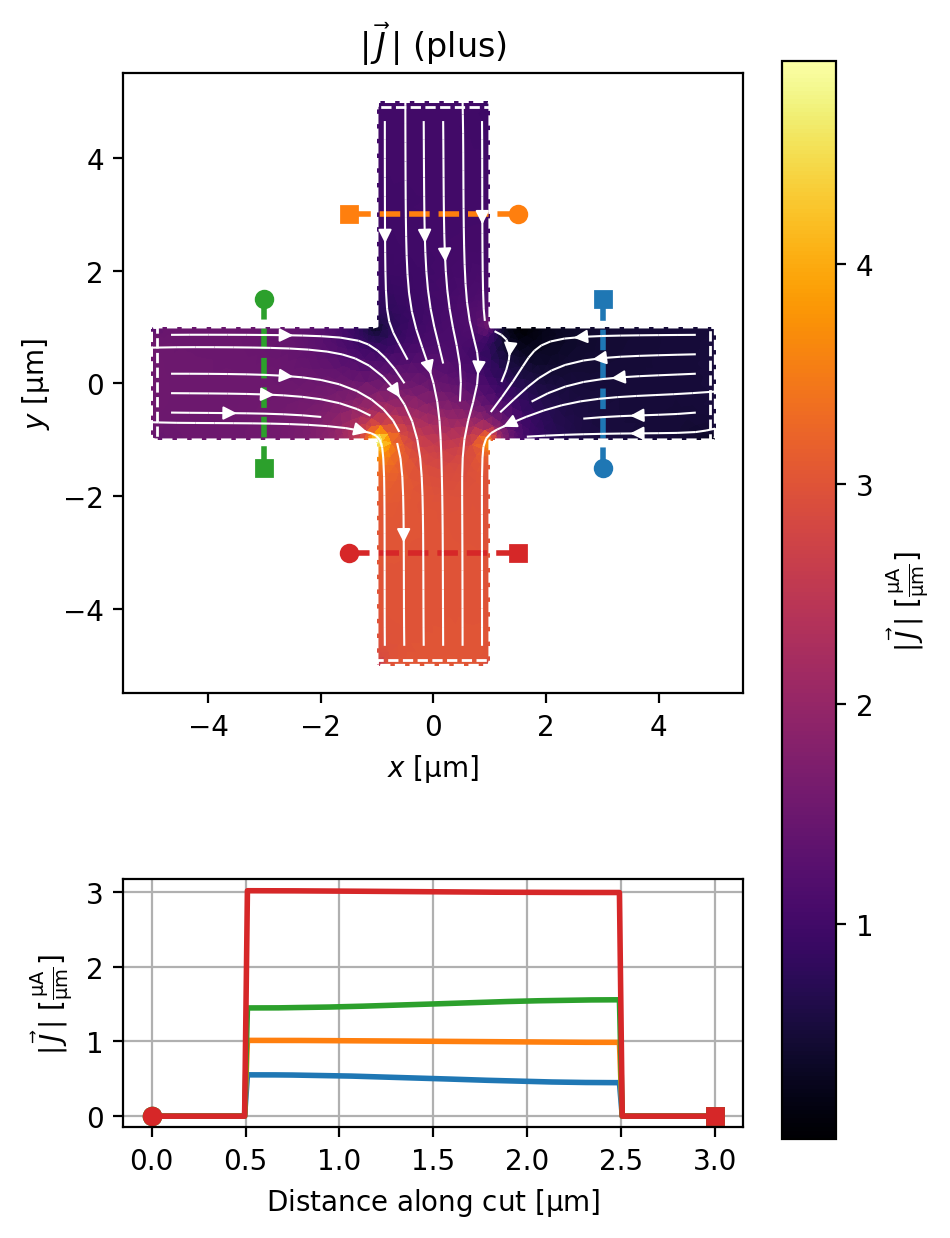

In [28]:
# Each terminal current can be a float, string, or pint.Quantity
terminal_currents = {
    "source1": "1 uA",
    "source2": sc.ureg("2 uA"),
    "source3": 3,
    "drain": "-6 uA",
}
solution = solve_and_plot_model({"plus": terminal_currents})

In the configuration below, both `drain` and `source1` will sink $2\,\mu\mathrm{m}$ of current.

source1: Total current -2.010 uA (-0.493% error)
source2: Total current 2.010 uA (0.500% error)
source3: Total current 2.010 uA (0.499% error)
drain: Total current -2.010 uA (-0.509% error)


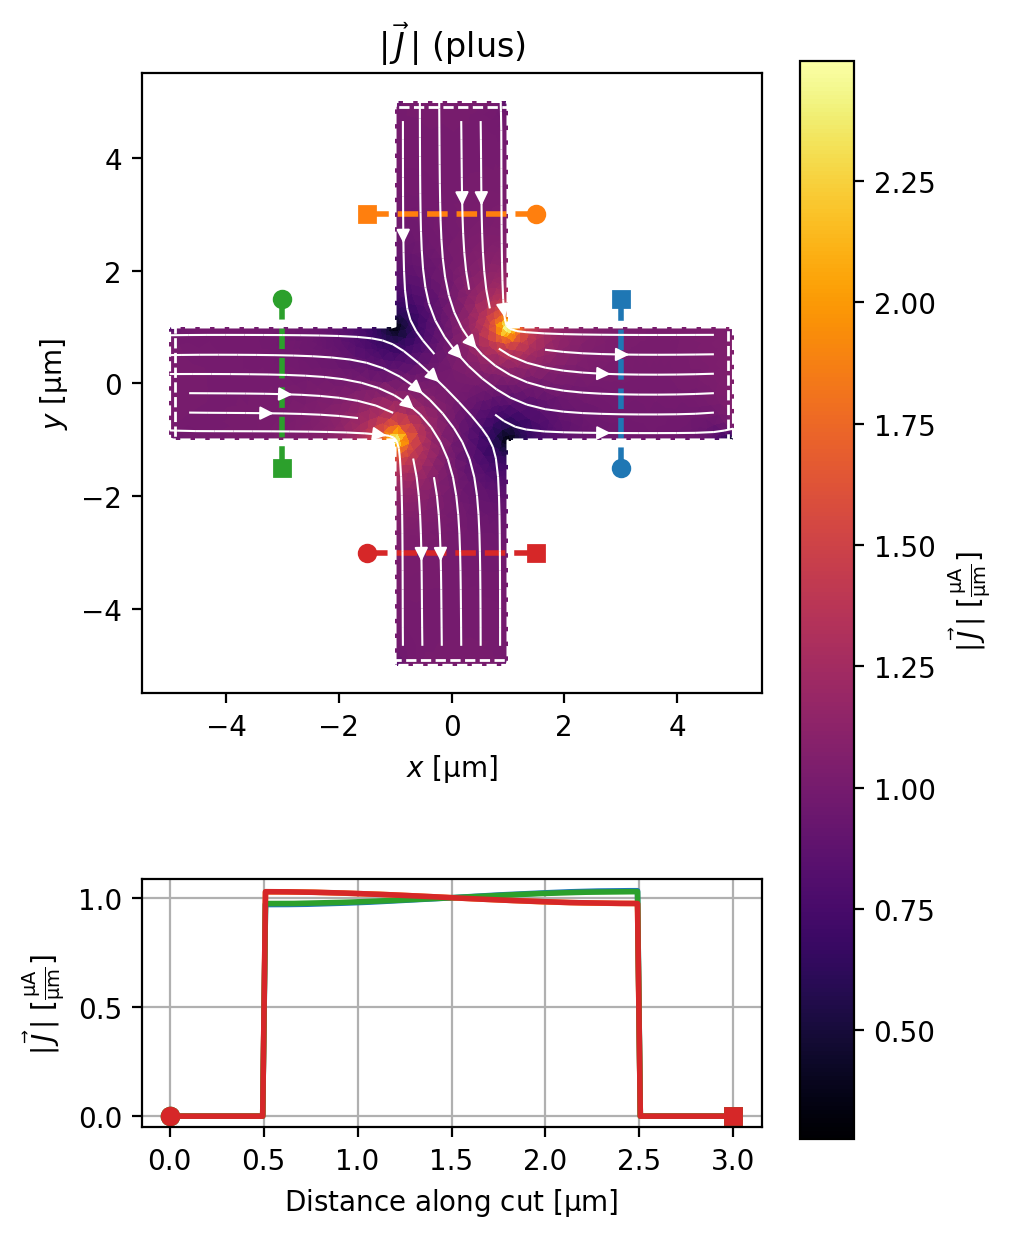

In [29]:
terminal_currents = {
    "source1": "-2 uA",
    "source2": "2 uA",
    "source3": "2 uA",
    "drain": "-2 uA",
}
solution = solve_and_plot_model({"plus": terminal_currents})

Of course, this all works with a non-zero applied field too.

source1: Total current 1.005 uA (0.519% error)
source2: Total current 2.004 uA (0.225% error)
source3: Total current 3.007 uA (0.226% error)
drain: Total current -6.039 uA (-0.648% error)


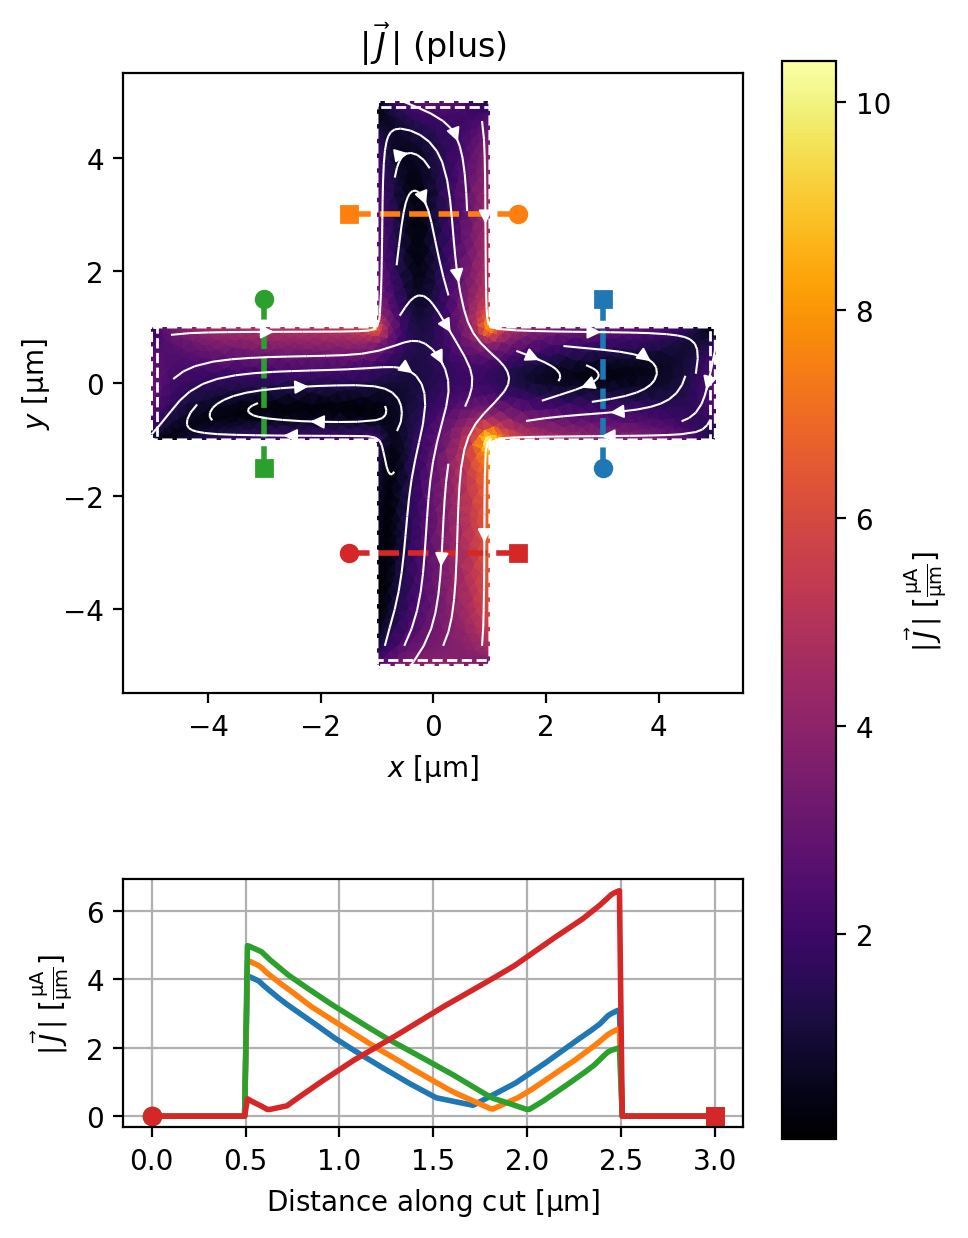

In [30]:
terminal_currents = {
    "source1": "1 uA",
    "source2": "2 uA",
    "source3": "3 uA",
    "drain": "-6 uA",
}
solution = solve_and_plot_model({"plus": terminal_currents}, applied_field="5 uT")